# Interpretable Machine Learning

_&copy; 2022 Ra Inta, for BH Analytics_

This notebook provides the code used to get the slides for the accompanying seminar _Interpretable Machine Learning_ (seminar 14 in the 2022 CDC Advanced Data Science Seminar series).

Import necessary packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from patsy import dmatrices

import statsmodels as sm
import statsmodels.formula.api as smf

import sklearn
from sklearn.metrics import confusion_matrix

C:\Users\r_int\Anaconda3\envs\awesome\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\r_int\Anaconda3\envs\awesome\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\r_int\Anaconda3\envs\awesome\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Make an `images` directory if if doesn't exist:

In [2]:
import os

if not os.path.isdir('images'):
    os.mkdir('images')

Print out module versions

In [3]:
def print_module_version(module):
    print(f"{module.__name__} version: {module.__version__}")

In [4]:
print_module_version(np)
print_module_version(pd)
print_module_version(mpl)
print_module_version(sns)
print_module_version(sklearn)
print_module_version(sm)

numpy version: 1.22.4
pandas version: 1.4.2
matplotlib version: 3.4.2
seaborn version: 0.11.1
sklearn version: 1.1.2
statsmodels version: 0.12.2


Set some plotting parameters:

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

## Regression: Health Insurance Charges

This dataset is an examination of health insurance charges in the US. Each row (1338 in total) is a patient over the collection period. The primary outcome is `charges`, the amount each patient (customer) is charged for health insurance during this period. The other variables are: Age, Sex, BMI, Number of Children, Smoker and Region of the US. 

There are no missing or undefined values in the dataset.

You may download this dataset from Kaggle:

https://www.kaggle.com/datasets/mirichoi0218/insurance



In [7]:
insurance = pd.read_csv('health_data/insurance.csv')

In [8]:
insurance.shape

(1338, 7)

In [9]:
insurance.isnull().mean()

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

Rename the columns so they read better on a plot:

In [10]:
insurance.rename(columns={x: x.title() for x in insurance.columns}, inplace=True)

insurance.rename(columns={'Bmi': 'BMI'}, inplace=True)

Examine the first five rows:

In [11]:
insurance.round(2).head()

,Age,Sex,BMI,Children,Smoker,Region,Charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


Perform a log-transform of the charges data:

In [12]:
insurance["Log(Charges)"] = np.log(insurance["Charges"] + 0.01)

In [13]:
sns.set_context("talk")

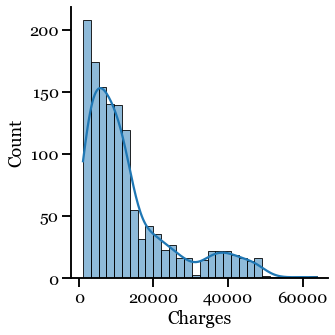

In [14]:
sns.displot(x="Charges", data=insurance, kde=True)
plt.savefig("images/insurance_charges_kde.png")

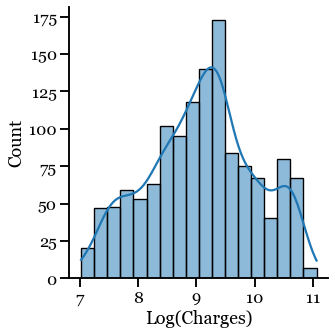

In [15]:
sns.displot(x="Log(Charges)", data=insurance, kde=True)
plt.savefig("images/insurance_log_charges_kde.png")

Teaser: plot the regression as a function of `Age`:

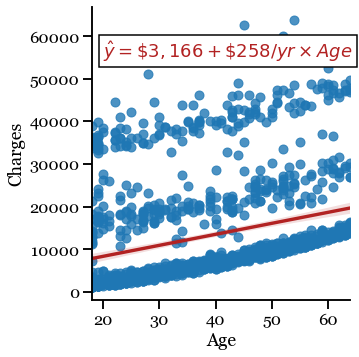

In [16]:
sns.lmplot(x="Age", y="Charges", line_kws={"color": "firebrick"}, data=insurance)

# Add annotations to the plot
plt.text(x=20, y=55000,
         s=r"$\hat{y} = \$3,166 + \$258/yr\times Age$",
         fontsize=18,
         bbox=dict(facecolor='white', alpha=1),
         color="firebrick")

plt.savefig("images/insurance_age_regression.png")

In [18]:
reg_age = smf.ols(formula="Charges ~ Age + Smoker + Region", data=insurance).fit()

reg_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Charges   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     692.2
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:51:06   Log-Likelihood:                -13621.
No. Observations:                1338   AIC:                         2.725e+04
Df Residuals:                    1332   BIC:                         2.729e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2317.5597    612.902     -3.781      0.000   -3519.918   -1115.201
Smoker[T.yes]         2.38e+04    434.612     54.755      0.000    2.29e+04    2.46e+04
Region[T.northwest]  -294.9712    502.270     -0.587      0.557   -1280.297     690.354
Region[T.southeast]   391.2493    488.878      0.800      0.424    -567.806    1350.304
Region[T.southwest]  -436.7129    502.272     -0.869      0.385   -1422.044     548.618
Age                   275.1037     12.454     22.089      0.000     250.671     299.536
==============================================================================
Omnibus:                      264.626   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.442
Skew:                           1.070   Prob(JB):                    3.81e-139
Kurtosis:                       5.618   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Compare to the log-transformed version:

In [12]:
reg_log_age = smf.ols(formula="Q('Log(Charges)') ~ Age + Smoker + Region", data=insurance).fit()

reg_log_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q('Log(Charges)')   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     764.5
Date:                Tue, 30 Aug 2022   Prob (F-statistic):               0.00
Time:                        02:06:40   Log-Likelihood:                -880.48
No. Observations:                1338   AIC:                             1773.
Df Residuals:                    1332   BIC:                             1804.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.4486      0.045    165.978      0.000       7.361       7.537
Smoker[T.yes]           1.5486      0.032     48.663      0.000       1.486       1.611
Region[T.northwest]    -0.0526      0.037     -1.431      0.153      -0.125       0.020
Region[T.southeast]    -0.1016      0.036     -2.837      0.005      -0.172      -0.031
Region[T.southwest]    -0.1005      0.037     -2.732      0.006      -0.173      -0.028
Age                     0.0357      0.001     39.094      0.000       0.034       0.037
==============================================================================
Omnibus:                      355.305   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1017.355
Skew:                           1.349   Prob(JB):                    1.21e-221
Kurtosis:                       6.312   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

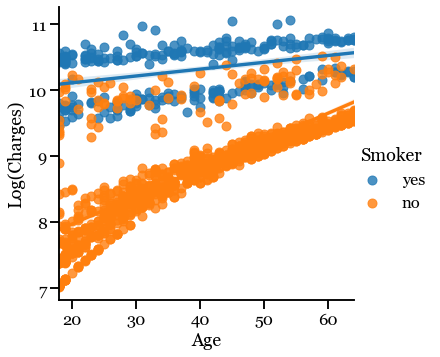

In [37]:
sns.lmplot(x="Age", y="Log(Charges)", hue="Smoker", data=insurance)

Examine interaction effects between `BMI` and `Smoker`, plus the effect of `Age`, on the outcome `Charges`:

In [13]:
reg_bmi_smoker = smf.ols(formula="Charges ~ BMI:Smoker + Age", data=insurance).fit()

reg_bmi_smoker.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Charges   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     2004.
Date:                Tue, 30 Aug 2022   Prob (F-statistic):               0.00
Time:                        02:06:46   Log-Likelihood:                -13336.
No. Observations:                1338   AIC:                         2.668e+04
Df Residuals:                    1334   BIC:                         2.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6590.1481    791.267     -8.329      0.000   -8142.411   -5037.885
BMI:Smoker[no]    145.3692     23.454      6.198      0.000      99.359     191.379
BMI:Smoker[yes]   947.6604     24.831     38.164      0.000     898.948     996.373
Age               264.1819     10.121     26.102      0.000     244.327     284.037
==============================================================================
Omnibus:                      580.348   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2723.438
Skew:                           2.040   Prob(JB):                         0.00
Kurtosis:                       8.675   Cond. No.                         272.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Perform Machine Learning Regression

In [14]:
formula = "Charges ~ Age + Smoker + Region"

formula

'Charges ~ Age + Smoker + Region'

In [15]:
## use Patsy to create model matrices
Y, X = dmatrices(formula, insurance)

In [16]:
## Split Data into training and sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=1729)

### For Kitchen-sink Models

'Age + Sex + BMI + Children + Smoker + Region'

In [46]:
formula_all = "Charges ~ " + " + ".join(insurance.columns[:6]) + " + BMI:Smoker"

formula_all

'Charges ~ Age + Sex + BMI + Children + Smoker + Region + BMI:Smoker'

In [47]:
## use Patsy to create model matrices
Y_all, X_all = dmatrices(formula_all, insurance)

In [48]:
## Split Data into training and sample
from sklearn.model_selection import train_test_split

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all,
                                                    Y_all,
                                                    test_size=0.25,
                                                    random_state=1729)

In [17]:
## import linear model
from sklearn import linear_model

## Define model parameters
reg = linear_model.LinearRegression()

## fit model using data with .fit
reg.fit(X_train, y_train)

LinearRegression()

In [18]:
reg.score(X_train, y_train)

0.7308932839435575

In [19]:
reg.score(X_test, y_test)

0.6965223967755583

### Apply some regularization:

In [64]:
lasso = linear_model.LassoCV(alphas=[0.01, 0.1, 1, 10, 1000, 10000]).fit(X_train, y_train.ravel())

In [65]:
lasso.score(X_train, y_train)

0.8361929790541449

In [66]:
lasso.score(X_test, y_test)

0.8537880085130801

In [67]:
lasso.alpha_

1.0

In [69]:
reg_full = linear_model.LinearRegression().fit(X, Y)

## fit model using data with .fit
reg.score(X, Y)

0.840720607469563

## Create Tree-based regression model

In [20]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

decision_tree = DecisionTreeRegressor(random_state=1729)

decision_tree.name = "Decision Tree"

decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1729)

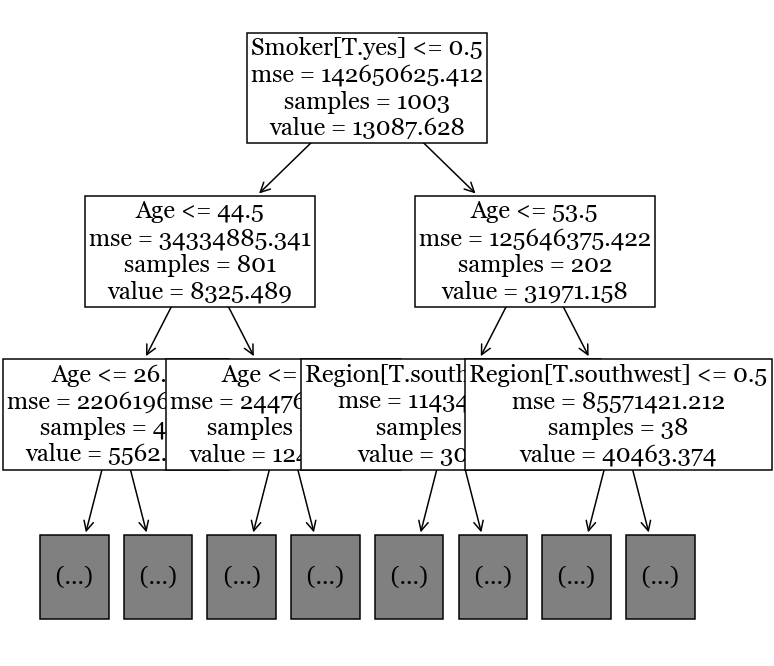

In [26]:
plt.figure(figsize=(12,12))

g = plot_tree(decision_tree, 
               fontsize=24, 
               feature_names=X.design_info.column_names,
               max_depth=2)

plt.savefig('images/decision_tree.png')

In [43]:
from itertools import product

age_ranges = np.linspace(18, 65, 100)

smoker = ["yes", "no"]

df_predict = pd.DataFrame(product(age_ranges, smoker), columns=["Age", "Smoker"])

df_predict["Region"] = "northeast"

df_predict["Charges"] = 0  # This will be dropped immediately

# Kludge to get all region levels
for region in ["northwest", "southeast", "southwest"]:
    df_predict = df_predict.append(df_predict.iloc[-1, :])
    df_predict.iat[-1, -2] = region

,Age,Smoker,Region,Charges
198,65.0,yes,northeast,0
199,65.0,no,northeast,0
199,65.0,no,northwest,0
199,65.0,no,southeast,0
199,65.0,no,southwest,0


In [44]:
Y_predict, X_predict = dmatrices("Charges ~ Age + Smoker + Region", df_predict)

In [46]:
df_predict["Charges (predicted)"] = decision_tree.predict(X_predict)

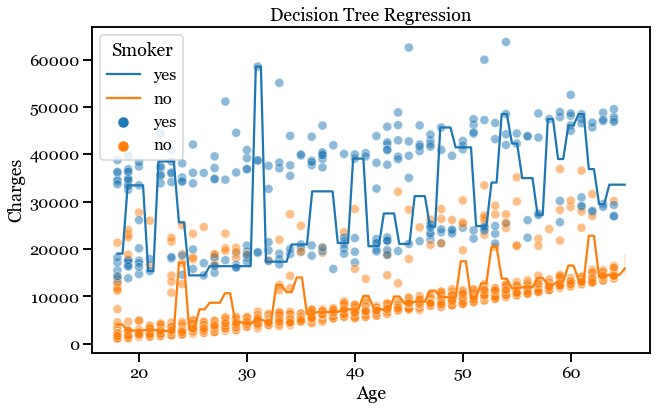

In [61]:
ax = sns.scatterplot(x="Age", hue="Smoker", y="Charges", data=insurance, alpha=0.5)


sns.lineplot(x="Age", y="Charges (predicted)", hue="Smoker", data=df_predict, ax=ax)
plt.title("Decision Tree Regression")

plt.savefig("images/decision_tree_lineplot.png")

In [21]:
decision_tree_less_depth = DecisionTreeRegressor(random_state=1729, max_depth=4)

decision_tree_less_depth.name = "Decision Tree (less depth)"

decision_tree_less_depth.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=1729)

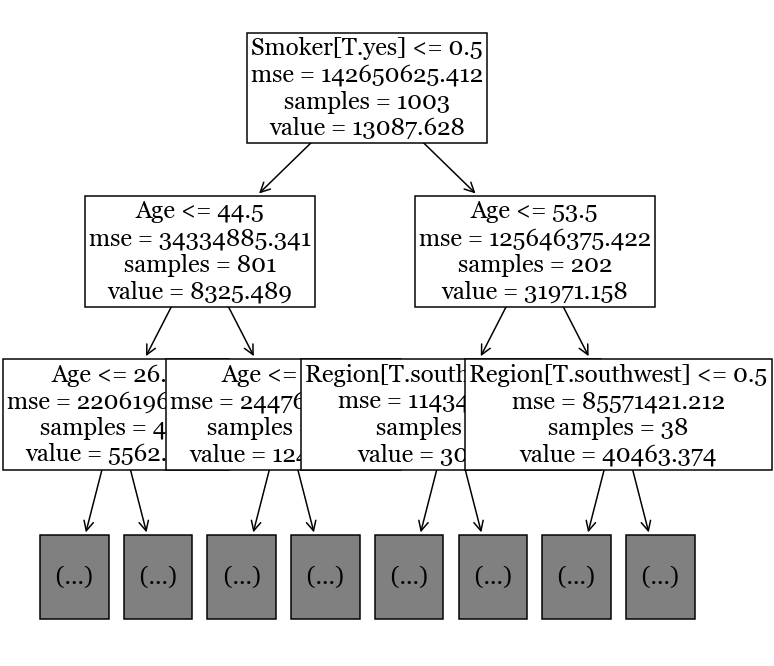

In [52]:
plt.figure(figsize=(12,12))

g = plot_tree(decision_tree_less_depth, 
               fontsize=24, 
               feature_names=X.design_info.column_names,
               max_depth=2)

plt.savefig('images/decision_tree_less_depth.png')

In [53]:
df_predict["Charges (predicted; less depth)"] = decision_tree_less_depth.predict(X_predict)

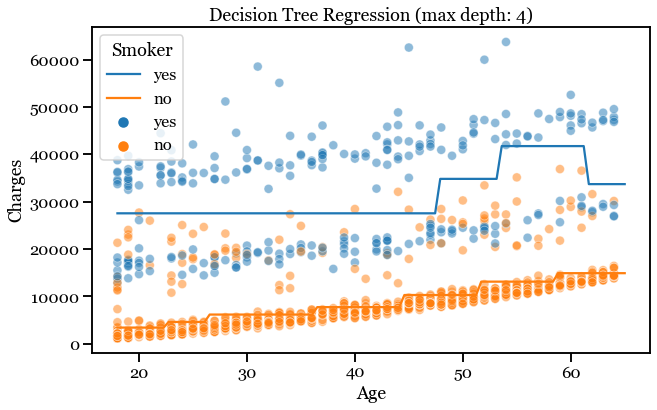

In [62]:
ax = sns.scatterplot(x="Age", hue="Smoker", y="Charges", data=insurance, alpha=0.5)

sns.lineplot(x="Age", y="Charges (predicted; less depth)", hue="Smoker", data=df_predict, ax=ax)
plt.title("Decision Tree Regression (max depth: 4)")

plt.savefig("images/decision_tree_less_depth_lineplot.png")

## Partial Dependence Plots (PDPs)



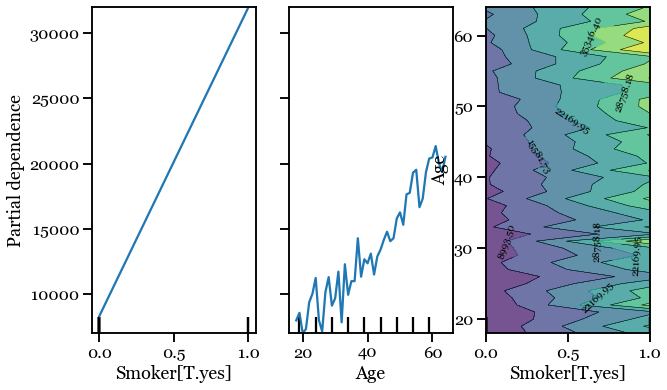

In [35]:
from sklearn.inspection import PartialDependenceDisplay

# Examine PDPs for Smoker and Age
# PartialDependenceDisplay.from_estimator(decision_tree, X, [1, 5, (1, 5)],
#                                         feature_names=["Smoker", "Age", ("Smoker", "Age")])
                                        
PartialDependenceDisplay.from_estimator(decision_tree, X, [1, 5, (1, 5)],
                                        feature_names=X.design_info.column_names)

plt.savefig("images/pdp_age_smoker.png")

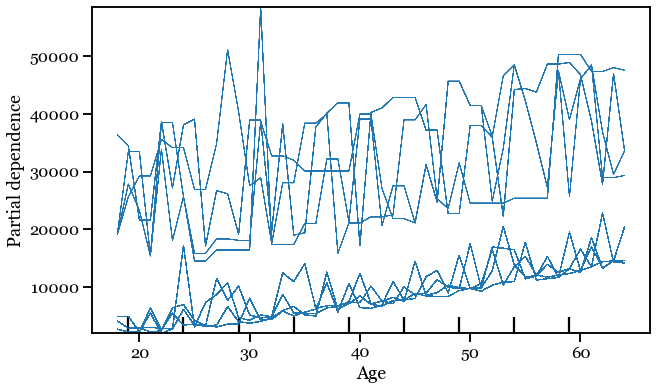

In [38]:
from sklearn.inspection import PartialDependenceDisplay

# Examine PDPs for Smoker and Age
# PartialDependenceDisplay.from_estimator(decision_tree, X, [1, 5, (1, 5)],
#                                         feature_names=["Smoker", "Age", ("Smoker", "Age")])
                                        
PartialDependenceDisplay.from_estimator(decision_tree, X, [5],
                                        feature_names=X.design_info.column_names, kind="individual")

plt.savefig("images/ice_age_smoker_decisionTree.png")

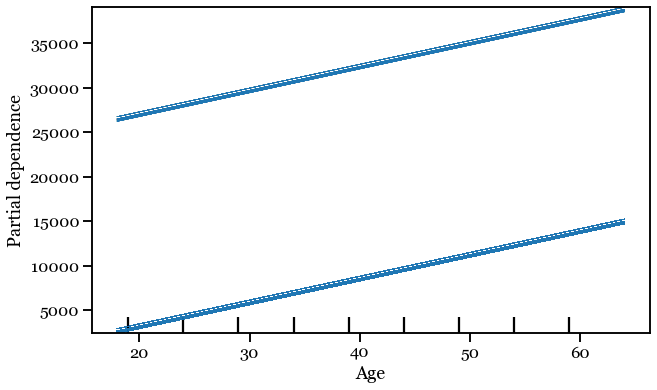

In [39]:
from sklearn.inspection import PartialDependenceDisplay

# Examine PDPs for Smoker and Age
# PartialDependenceDisplay.from_estimator(decision_tree, X, [1, 5, (1, 5)],
#                                         feature_names=["Smoker", "Age", ("Smoker", "Age")])
                                        
PartialDependenceDisplay.from_estimator(reg, X, [5],
                                        feature_names=X.design_info.column_names, kind="individual")

plt.savefig("images/ice_age_smoker_linearRegression.png")

### Permutation Feature Importance

In [49]:
decision_tree_all = DecisionTreeRegressor(random_state=1729)

decision_tree_all.name = "Decision Tree (all)"

decision_tree_all.fit(X_all_train, y_all_train)

DecisionTreeRegressor(random_state=1729)

In [56]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(decision_tree_all, random_state=1729).fit(X_all_train, y_all_train)
eli5.show_weights(perm, feature_names=X_all.design_info.column_names)

Weight,Feature
1.5714 ± 0.1358,BMI:Smoker[T.yes]
0.4397 ± 0.0462,Age
0.1776 ± 0.0211,BMI
0.1377 ± 0.0049,Children
0.0570 ± 0.0167,Region[T.southeast]
0.0399 ± 0.0137,Sex[T.male]
0.0350 ± 0.0123,Region[T.northwest]
0.0194 ± 0.0082,Region[T.southwest]
0.0038 ± 0.0016,Smoker[T.yes]
0 ± 0.0000,Intercept


### Global Surrogate Models

In [57]:
from xgboost import XGBRegressor

xgb_reg_all = XGBRegressor(random_state=1729)

In [60]:
xgb_reg_all.fit(X_all_train, y_all_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             random_state=1729, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [65]:
xgb_reg_all.score(X_all_train, y_all_train)

0.9945082767777285

In [63]:
xgb_reg_all.score(X_all_test, y_all_test)

0.8003681894537595

In [ ]:
xgb_reg_all = XGBRegressor(random_state=1729)

Sneaky trick to tell `scikit-learn` the XGBoost model was fitted:

In [80]:
xgb_reg_all.fitted_ = True

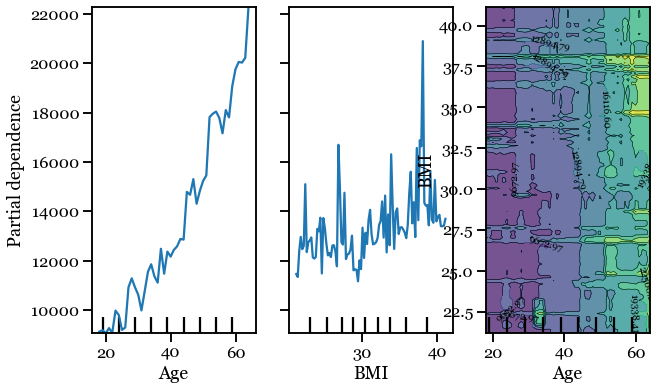

In [85]:
PartialDependenceDisplay.from_estimator(xgb_reg_all, X_all, [6, 7, (6, 7)],
                                        feature_names=X_all.design_info.column_names)

plt.savefig("images/pdp_age_smoker_xgb.png")

In [86]:
insurance["predict_xgb"] = xgb_reg_all.predict(X_all)

In [87]:
formula_all

'Charges ~ Age + Sex + BMI + Children + Smoker + Region + BMI:Smoker'

In [88]:
global_surrogate = smf.ols(
    formula="predict_xgb ~ Age + Sex + BMI + Children + Smoker + Region + BMI:Smoker",
    data=insurance).fit()

global_surrogate.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            predict_xgb   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1094.
Date:                Tue, 30 Aug 2022   Prob (F-statistic):               0.00
Time:                        03:14:32   Log-Likelihood:                -13011.
No. Observations:                1338   AIC:                         2.604e+04
Df Residuals:                    1328   BIC:                         2.609e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2140.0087    725.236     -2.951      0.003   -3562.743    -717.275
Sex[T.male]          -641.0472    223.297     -2.871      0.004   -1079.100    -202.994
Smoker[T.yes]       -2.009e+04   1380.978    -14.548      0.000   -2.28e+04   -1.74e+04
Region[T.northwest]  -600.0731    319.096     -1.881      0.060   -1226.060      25.914
Region[T.southeast] -1631.4844    320.680     -5.088      0.000   -2260.579   -1002.390
Region[T.southwest] -1037.6910    320.234     -3.240      0.001   -1665.911    -409.471
Age                   259.7815      7.973     32.584      0.000     244.141     275.422
BMI                    26.1538     21.449      1.219      0.223     -15.924      68.231
BMI:Smoker[T.yes]    1428.6531     44.109     32.389      0.000    1342.122    1515.185
Children              551.0676     92.312      5.970      0.000     369.975     732.160
==============================================================================
Omnibus:                      613.740   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3334.508
Skew:                           2.113   Prob(JB):                         0.00
Kurtosis:                       9.477   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### LIME

In [91]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_all_train, 
feature_names=X_all.design_info.column_names, 
class_names=['Charges'], 
# categorical_features=categorical_features, 
verbose=True, mode='regression')


In [93]:
i = 25
exp = explainer.explain_instance(X_all_test[i], xgb_reg_all.predict, num_features=5)

Intercept 33702.90738754268
Prediction_local [9590.55039618]
Right: 6112.0938


In [94]:
exp.show_in_notebook(show_table=True)

In [95]:
exp.as_list()

[('BMI:Smoker[T.yes] <= 0.00', -18594.45141738375),
 ('Smoker[T.yes] <= 0.00', -7192.909209004142),
 ('39.00 < Age <= 52.00', 1355.8819948062658),
 ('Region[T.southeast] <= 0.00', 971.5721215198511),
 ('0.00 < Sex[T.male] <= 1.00', -652.4504813048209)]

In [100]:
with open("images/LIME.html", 'w', encoding="utf-8") as f:
    f.write(exp.as_html())

### SHAP

In [121]:
import shap

explainer = shap.Explainer(xgb_reg_all)

shap_values = explainer(X_all)




ntree_limit is deprecated, use `iteration_range` or model slicing instead.


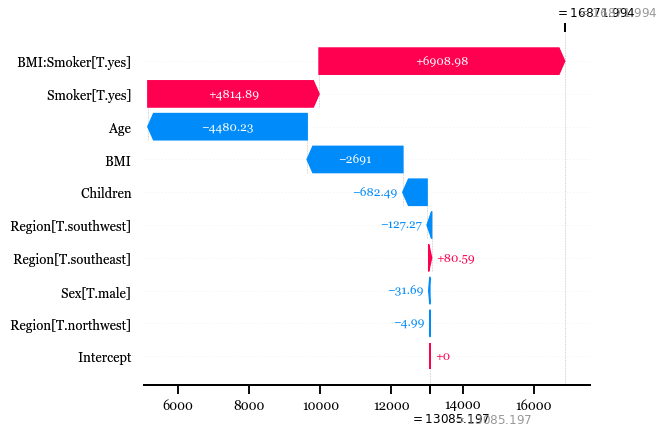

In [122]:
from shap.plots import _waterfall
_waterfall.waterfall_legacy(explainer.expected_value, 
shap_values[0].values, 
X_all[:, 0], 
feature_names=X_all.design_info.column_names)

---